### Overview
* **Tensorflow structual time series** -
    * Trend
    * Seasonality - multiple (weekly, monthly, yearly)
    * Exogenous impacts - linear regression 
    * AutoRegressive - more weight to closer data points
    * Noise
    * **Pros/Cons**:
        * Flexible, good with short-term dynamics, accomodates exogenous regressors, intuitive
        * Complex model setup, model fitting takes time
    * **Tensorflow Probability** package - **Structural Time Series (STS)**
        * Library built on TensorFlow; makes it easy to combine probabilistic models and deep learning. [webpage](https://www.tensorflow.org/probability)
        * Juan's [blog post](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html)

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None

# Model
import tensorflow_probability as tfp

# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Suppress 'futurewarnings' from Statsmodels and TSA
# import warnings
# warnings.filterwarnings("ignore")

## Intro using Bike Sharing [dataset](https://www.kaggle.com/datasets/contactprad/bike-share-daily-data)

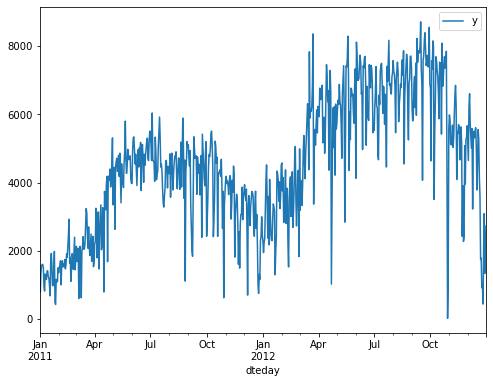

In [2]:
df = pd.read_csv('data/daily_bike_sharing.csv', index_col='dteday', parse_dates=True)
df = df.loc[:,['cnt', 'holiday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df = df.rename(columns={'cnt':'y'})
df = df.asfreq('D')
df['y'].plot(figsize=(8,6), legend=True);

In [3]:
df.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [4]:
# Train, Test split
test_period = 31
train = df.iloc[:-test_period, :]['y']
test  = df.iloc[-test_period:, :]['y']
print(train.shape, test.shape)

(700,) (31,)


In [5]:
# Exogenous Variables - KEEP TRAIN & TEST together

exog = np.matrix(df.drop(columns='y'))
exog[:1]
exog.shape

(731, 7)

In [6]:
train = train.astype(float)
test  = test.astype(float)
train

dteday
2011-01-01     985.0
2011-01-02     801.0
2011-01-03    1349.0
2011-01-04    1562.0
2011-01-05    1600.0
               ...  
2012-11-26    5087.0
2012-11-27    3959.0
2012-11-28    5260.0
2012-11-29    5323.0
2012-11-30    5668.0
Freq: D, Name: y, Length: 700, dtype: float64

## Setting up Components
### >> Autoregression & Trend

In [7]:
trend = tfp.sts.LocalLinearTrend(observed_time_series=train,
                                name = 'trend')

In [8]:
ar = tfp.sts.Autoregressive(observed_time_series=train,
                            order = 1, name ='autoregressive')

### >> Seasonality

In [9]:
# Weekly seasonality

weekday_effect = tfp.sts.Seasonal(observed_time_series=train,
                                  num_seasons=7, num_steps_per_season=1, 
                                  name='seasonality_weekly')

In [10]:
# Annual seasonality
days_per_month = np.array([[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
                           [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]])

monthly_effect = tfp.sts.Seasonal(observed_time_series=train,
                                  num_seasons=12, num_steps_per_season=days_per_month, 
                                  name='seasonality_yearly')

### >> Linear regression

In [11]:
regressor = tfp.sts.LinearRegression(design_matrix = exog,
                                    name = 'regressors')

## Setting up Model
### >> Sum (~compiling the model)

In [12]:
model = tfp.sts.Sum([trend, ar, weekday_effect, monthly_effect, regressor],
                   observed_time_series=train)

### >> Fitting & Predicting

In [13]:
# Hamiltonian Monte-Carlo method used for estimation

samples, kernel_results = tfp.sts.fit_with_hmc(model=model, 
                                               observed_time_series=train,
                                               num_results=100, num_warmup_steps=50,
                                               num_leapfrog_steps=15, seed=1502,
                                               num_variational_steps=150)

C:\Users\uditg\anaconda3\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [14]:
# Forecast
preds = tfp.sts.forecast(model=model, observed_time_series=train,
                         parameter_samples=samples,
                         num_steps_forecast = test_period)

In [15]:
preds = pd.Series(preds.mean()[:,0], index = test.index)
preds

dteday
2012-12-01    4326.308167
2012-12-02    3553.651507
2012-12-03    4454.079690
2012-12-04    4512.662910
2012-12-05    4765.924157
2012-12-06    4738.324854
2012-12-07    3997.756437
2012-12-08    3950.026479
2012-12-09    3329.701090
2012-12-10    3548.469389
2012-12-11    3626.916682
2012-12-12    3887.098549
2012-12-13    4598.139180
2012-12-14    4593.789744
2012-12-15    4546.738853
2012-12-16    3190.966037
2012-12-17    3409.622005
2012-12-18    4223.519833
2012-12-19    4483.423622
2012-12-20    3723.742035
2012-12-21    3719.733698
2012-12-22    4407.767718
2012-12-23    3787.800478
2012-12-24    3270.500036
2012-12-25    3344.387723
2012-12-26    2872.878519
2012-12-27    3584.276809
2012-12-28    3580.852752
2012-12-29    3533.159972
2012-12-30    3648.742241
2012-12-31    3132.078907
Freq: D, dtype: float64

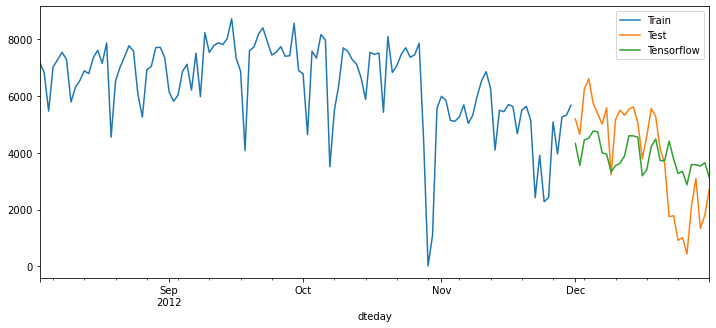

In [17]:
plt.figure(figsize = (12,5))
train[-120:].plot(label = 'Train');
test.plot(label = 'Test');
preds.plot(label = 'Tensorflow');
plt.legend(loc='best');

In [18]:
print('Average level: ', round(df['y'].mean(),0))
print('MAE:  ', mean_absolute_error(test, preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test, preds)).round(0))
print('MAPE: ', round(((test - preds)/test).abs().mean()*100,2))

Average level:  4504.0
MAE:   1294.0
RMSE:  1480.0
MAPE:  67.08


In [19]:
preds.to_csv('preds_tfp.csv')

---
## Example - Wikipedia page visits

In [26]:
df = pd.read_csv('data/udemy_wikipedia_visits.csv', index_col='Date', parse_dates=True)

In [27]:
df.head()

,Udemy,Easter,Christmas
Date,,,
2016-01-01,311,0,0
2016-01-02,564,0,0
2016-01-03,517,0,0
2016-01-04,652,0,0
2016-01-05,756,0,0


In [34]:
df.shape

(1827, 3)

In [29]:
df = df.asfreq('D')
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1827, freq='D')

In [30]:
df.isna().sum()

Udemy        0
Easter       0
Christmas    0
dtype: int64

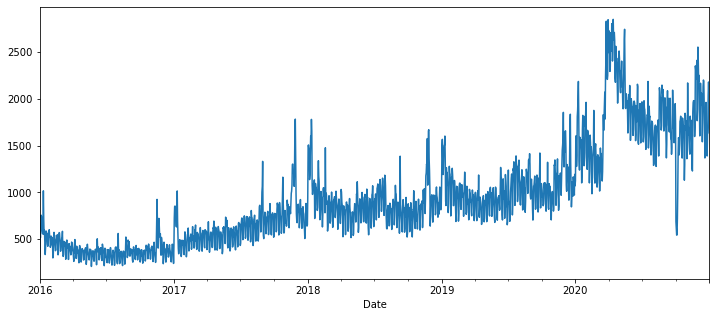

In [33]:
df['Udemy'].plot(figsize=(12,5));

In [37]:
# Train, Test split
test_period = 31
train = df.iloc[:-test_period, :]['Udemy'].astype(float)
test  = df.iloc[-test_period:, :]['Udemy'].astype(float)
print(train.shape, test.shape)
train[:5]

(1796,) (31,)


Date
2016-01-01    311.0
2016-01-02    564.0
2016-01-03    517.0
2016-01-04    652.0
2016-01-05    756.0
Freq: D, Name: Udemy, dtype: float64

In [42]:
exog = np.matrix(df.drop(columns='Udemy').astype(float))  # matrix to 'regressor' should be float type
print(exog.shape)
exog[:2]

(1827, 2)


matrix([[0., 0.],
        [0., 0.]])

In [49]:
trend = tfp.sts.LocalLinearTrend(observed_time_series=train, name = 'trend')

ar = tfp.sts.Autoregressive(observed_time_series=train, order = 1, name ='autoregressive')

weekday_effect = tfp.sts.Seasonal(observed_time_series=train,
                                  num_seasons=7, num_steps_per_season=1, 
                                  name='seasonality_weekly')

days_per_month = np.array([[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
                           [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
                           [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
                           [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]])

monthly_effect = tfp.sts.Seasonal(observed_time_series=train,
                                  num_seasons=12, num_steps_per_season=days_per_month, 
                                  name='seasonality_yearly')

regressor = tfp.sts.LinearRegression(design_matrix = exog, name = 'regressors')

In [50]:
model = tfp.sts.Sum([trend, ar, weekday_effect, monthly_effect, regressor],
                    observed_time_series=train)

In [71]:
samples, kernel_results = tfp.sts.fit_with_hmc(model=model, 
                                               observed_time_series=train,
                                               num_results=100, num_warmup_steps=50,
                                               num_leapfrog_steps=15, seed=1502,
                                               num_variational_steps=150)

C:\Users\uditg\anaconda3\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [72]:
preds = tfp.sts.forecast(model=model, observed_time_series=train,
                         parameter_samples=samples,
                         num_steps_forecast = test_period)

In [73]:
preds = pd.Series(preds.mean()[:,0], index = test.index)
preds[:5]

Date
2020-12-01    2501.666030
2020-12-02    2441.973505
2020-12-03    2426.764468
2020-12-04    2304.705915
2020-12-05    2050.990376
Freq: D, dtype: float64

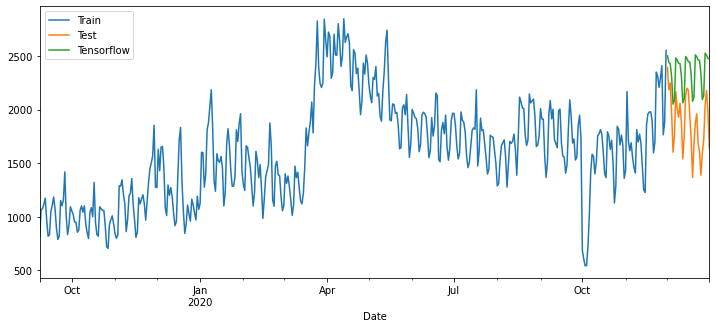

In [74]:
plt.figure(figsize = (12,5))
train[-450:].plot(label = 'Train');
test.plot(label = 'Test');
preds.plot(label = 'Tensorflow');
plt.legend(loc='best');